ในการเทรน Machine Learning โดยเฉพาะแบบ Supervised Learning หรือข้อมูลมี Label นอกจากเรื่องการเทรน การออกแบบสถาปัตยกรรมของโมเดล ยังมีงานสำคัญอีกหลายที่ต้องทำก่อนที่เราจะเริ่มเทรนได้ หนึ่งในนั้นคือ จัดเตรียมข้อมูลตั้งแต่ต้นทางไม่ว่าจะเป็น ไฟล์รูปภาพ ไฟล์ข้อความ ไฟล์เสียง ข้อมูลตาราง [Tabular](https://www.bualabs.com/archives/958/machine-learning-deep-learning-structure-data-tabular-data-ep-1/) ให้อยู่ในรูปแบบที่โมเดลนำไปใช้ได้ มีขั้นตอนดังนี้

1. List All Examples / Get Files - ดึงรายการข้อมูลทั้งหมดใน Dataset (ชื่อไฟล์)
    * tfms - พ่วงด้วย Transform ที่จำเป็น
1. Split to Training Set, Validation Set - แบ่งข้อมูลออกเป็น Training Set, Validation Set
    * by Random %, Folder name, CSV, ... - ด้วยวิธีต่าง ๆ เช่น Random %, ตามไฟล์เดอร์, ตามที่ระบุในไฟล์ CSV, ...
1. Label - แปะ Label ให้กับข้อมูล สำหรับงาน Supervised Learning
    * Folder name, File name, CSV, ... - จากชื่อโฟลเดอร์, ชื่อไฟล์, ตามที่ระบุใน CSV, etc. โดย Label ของ Validation Set จะขึ้นกับ Training Set
1. Transform (Optional) - แปลงข้อมูล โดย Transform ของ Validation Set จะขึ้นกับ Training Set
    * per Example/Image - ต่อ 1 ตัวอย่าง เช่น แปลง Channel รูป, Resize รูป, etc.
    * per Training Set - Normalize, Fill N/A wtih Median, Categorize, Tokenize, Numericalize, etc.
1. To Tensor - แปลงเป็น Tensor เนื่องจาก PyTorch รับ Tensor
1. DataLoader to Batch - เราไม่สามารถโหลดทั้ง Dataset ได้พร้อมกัน เราจำเป็นต้องใช้ DataLoader แบ่งข้อมูลออกเป็น Batch (Lazy Loading)
1. Transform per Batch - แปลงข้อมูล ต่อ Batch
1. DataBunch - สร้าง DataBunch ห่อ Training Set, Validation Set
1. Add Test Set (Optional) - เพิ่มข้อมูล Test Set (ถ้ามี)

# 0. Magic Commands


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [0]:
from fastai import *
from fastai.vision import *


# 2. Data

ใช้ชุดข้อมูล Imagenette 160 ซึ่งเป็น Subset ของ ImageNet แต่มีแค่ 10 Category ที่แตกต่างกันมาก ๆ

In [0]:
path = untar_data(URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette-160')

In [0]:
import PIL, os, mimetypes
Path.ls = lambda x : list(x.iterdir())

ls ดูใน Folder

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette-160/val'),
 PosixPath('/root/.fastai/data/imagenette-160/train')]

ls ดูใน Folder ชื่อ val

In [0]:
(path/'val').ls()

[PosixPath('/root/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n03394916')]

จะพบ 10 Folder สำหรับ 10 Category เราจะดู Category แรก ชื่อ tench เป็นปลาชนิดหนึ่ง

In [0]:
path_tench = path/'val'/'n01440764'

ดูไฟล์แรกใน Folder tench

In [0]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')

ใช้ PIL เปิดไฟล์ดูรูป

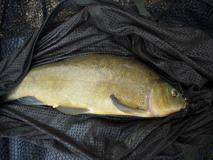

In [0]:
img = PIL.Image.open(img_fn)
img

ใช้ MatPlotLib แสดงรูป

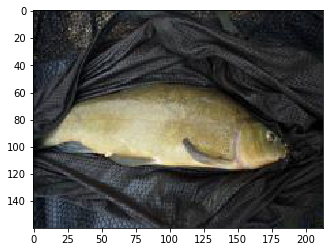

In [0]:
plt.imshow(img)

เราจะใช้ numpy เพื่อดูข้อมูลในรูป ในรูปแบบ Array ตัวเลข 

In [0]:
import numpy as np

In [0]:
imga = np.array(img)

จะเห็นว่า รูปมี 3 Channel เป็นรูปสี

In [0]:
imga.shape

(160, 213, 3)

In [0]:
imga[:10, :10, 0]

array([[44, 34, 16, 29, ..., 28, 21, 18, 33],
       [45, 33, 26, 48, ..., 22, 22, 15, 37],
       [45, 24, 20, 48, ..., 16, 19, 15, 37],
       [38, 15, 11, 29, ..., 17, 15, 23, 27],
       ...,
       [33, 39, 65, 44, ..., 13, 26, 35, 22],
       [51, 25, 34, 23, ...,  8, 19, 17, 32],
       [47, 15, 24, 40, ..., 14, 20, 32, 26],
       [42, 30, 33, 31, ..., 31, 33, 29, 27]], dtype=uint8)

# 3. Get Files

ไฟล์รูปมีนามสกุลอะไรบ้าง เราจะดึงมาจาก MIME Type 

In [0]:
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith('image/'))

In [0]:
' '.join(image_extensions)

'.ico .jpf .xpm .gif .art .svgz .bmp .jpg .wbmp .pbm .cdt .tiff .xwd .cr2 .djvu .jpe .ief .tif .ppm .jp2 .erf .djv .xbm .png .orf .psd .svg .cpt .crw .jpg2 .jng .pat .pgm .pnm .cdr .rgb .jpx .ras .pcx .jpeg .nef .jpm'

ประกาศ Utility ฟังก์ชันสำหรับแปลงเป็น Set

In [0]:
def setify(o): return o if isinstance(o, set) else set(listify(o))

ประกาศ Private ฟังก์ชัน สำหรับ Get List of Files จาก 1 Directory, รายการชื่อไฟล์, และนามสกุลที่ต้องการ

In [0]:
def _get_files(p, fns, extensions=None):
    p = Path(p)
    res = [p/fn for fn in fns if not fn.startswith('.')
        and ((not extensions) or f'.{fn.split(".")[-1].lower()}' in extensions)]
    return res

ลองใช้ _get_files กับ รายการไฟล์ใน path_tench เอาเฉพาะไฟล์รูป แล้วแสดง 5 รายการแรก

In [0]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path_tench, t, extensions=image_extensions)
t[:5]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00031333.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024235.JPEG')]

ประกาศฟังก์ชัน get_files สำหรับ Recursive ดูไฟล์ใน Folder ย่อย ๆ ลงไป ทั้งหมด

In [0]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}

    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path)): # dirpath, dirnames, filenames
            if include is not None and i==0:    d[:] = [o for o in d if o in include]
            else:                               d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        fns = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, fns, extensions)


ลอง Get Files ในโฟลเดอร์ ปลา tench แล้วแสดง 5 ไฟล์แรก

In [0]:
get_files(path_tench, image_extensions)[:5]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00031333.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024235.JPEG')]

Get Files ทั้งหมดใน Dataset แล้วแสดงรายการที่ 100-110

In [0]:
get_files(path, image_extensions, recurse=True)[100:110]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00031333.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00034654.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024235.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00045866.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00026397.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00048969.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG')]

ใน Dataset มีทั้งหมด 13,394 ไฟล์

In [0]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

ลองจับเวลา หมื่นกว่าไฟล์ ใช้เวลาแค่ ไม่ถึง 80 Millisecond เท่านั้น เนื่องจากเราใช้ os.scandir, os.walk ที่เป็นแค่ Layer บาง ๆ บน API ภาษา C ที่ทำงานโดยตรงกับ OS

In [0]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

10 loops, best of 3: 73.9 ms per loop


## 3.1 ItemList

ItemList เป็น Class ที่สร้างขึ้นมาจาก ListContainer ที่ใช้แทน Numpy Array เอาไว้สำหรับเก็บรายการข้อมูลตัวอย่าง ที่อยู่ใน path และรองรับการ Transform ข้อมูล tfms ที่จะถูกเรียกขึ้นมา Transform ข้อมูลตาม \_order ที่กำหนด

เราสามารถ Subclass ItemList เป็น class ที่ใช้ในงานเฉพาะ เช่น ImageList, TextList, TabularList, PointsItemList, CategoryList

In [0]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx): 
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self) # boolean mask
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + '...]'
        return res
     
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'

    def new(self, items, cls=None):
        if cls is None: cls = self.__class__
        return cls(items, self.path, self.tfms)

    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)


เราจะประกาศ ImageList จากการ Subclass ItemList เพื่อใช้เก็บข้อมูลเตัวอย่างแบบรูปภาพ โดยกำหนดพฤติกรรม เฉพาะสำหรับรูปภาพ เช่น from_files ให้เอาเฉพาะไฟล์นามสกุลเกี่ยวกับรูป ในโฟลเดอร์ที่กำหนด, get คือ เปิดรูปจากชื่อไฟล์ เป็นต้น

In [0]:

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)


ประกาศฟังก์ชัน Compose สำหรับใช้กับ List ของ Transform Function 

Compose คือ Concept ว่าเรามี List ของ Function อยู่ แล้วใช้ Output เป็น Input ของฟังก์ชันต่อไป ซ้อนกันไปเรื่อย ๆ เช่น x = f(x, **kwargs)

In [0]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

ประกาศ Base Class ของ Transform ที่จะใช้ Transform ItemList คือไม่มี method อะไรเลย เนื่องจากใช้ dunder call เป็นตัวทำงาน มีแต่ _order เท่านั้น ใช้ลำดับว่าทำอะไรก่อนหลัง เช่น ปรับ Channel รูป ต้องทำแต่เนิ่น ๆ แต่ Normalize, Categorize ต้องทำหลังจากอันอื่น ๆ

In [0]:
class Transform(): _order = 0

class MakeRGB(Transform): 
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

ใช้ ImageList.from_files Factory Method สร้าง Instance ของ ImageList จากไฟล์รูปทั้งหมดใน path ของ Dataset

In [0]:
il = ImageList.from_files(path, tfms=make_rgb)
il

ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00031412.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00048059.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00018006.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00005996.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00017866.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00022252.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00007186.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00018516.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00001432.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00033364.JPEG')...]
Path: /root/.fastai/data/imagenette-160

ลองดูรูปแรก เปิดรูป

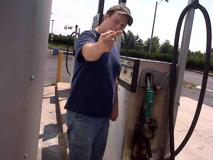

In [0]:
img = il[0]; img

ใส่ใน List เพื่อดู Metadata

In [0]:
il[:1]

[<PIL.Image.Image image mode=RGB size=213x160 at 0x7F4475820F98>]

# 4. Split to Training Set, Validation Set

แยกชุดข้อมูล Dataset ออกเป็น [Train / Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) ใน Machine Learning 

In [0]:
fn = il.items[0]; fn

PosixPath('/root/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00031412.JPEG')

ในเคสนี้ Dataset นี้แยกมาให้จาก 
* Folder ระดับแรก เป็น train/val
* Folder ระดับ 2 เป็น Class หรือ Label นั่นเอง

In [0]:
fn.parent.parent.name

'val'

ประกาศฟังก์ชัน split_by_func ที่จะ Delegate งานตัดสินว่าให้ข้อมูลตัวอย่างไหน อยู่ใน train หรือ val จากฟังก์ชัน f ที่รับเข้ามา 

และประกาศฟังก์ชัน grandparent_splitter ที่ดูจาก Folder parent.parent เพื่อไว้สำหรับ Pass ให้ split\_by\_func 

In [0]:
def split_by_func(items, f):
    mask = [f(o) for o in items]
    # filter out None value
    f = [o for o, m in zip(items, mask) if m == False]
    t = [o for o, m in zip(items, mask) if m == True]
    return f, t
    
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp == valid_name else False if gp == train_name else None

สร้าง Partial splitter โดย Fix valid_name โฟลเดอร์ เป็น val

In [0]:
splitter = partial(grandparent_splitter, valid_name='val')

ทดสอบ จับเวลา พบว่าทำงานได้เร็วมาก หลัก 40 Millisecond

In [0]:
% time train, valid = split_by_func(il, splitter)

CPU times: user 36.1 ms, sys: 0 ns, total: 36.1 ms
Wall time: 36.3 ms


Split ออกมาแล้วได้ Training Set จำนวน 12,894 ตัวอย่าง และ Validation Set จำนวน 500 ตัวอย่าง

In [0]:
len(train), len(valid)

(12894, 500)

นำโค้ดด้านบน มาใส่ไว้เป็น Factory Method ใน Class ชื่อ SplitData เพื่อ Instance จะได้ Wrap ตัว ItemList ของ Training Set และ Validation Set เอาไว้ด้วย

In [0]:
class SplitData():
    def __init__(self, train, valid): self.train, self.valid = train, valid

    def __getattr__(self, k): return getattr(train, k)

    # for pickle to save / load data
    def __setstate__(self, data:Any): self.__dict__.update(data)

    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'


เรียกใช้ SplitData.split_by_func Factory Method สร้าง instance ของ SplitData แล้ว print

In [0]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_14573.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_1792.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_16920.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_21134.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_6664.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_14266.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_10118.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_10527.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_2423.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_19156.JPEG')...]
Path: /root/.fastai/data/imagenette-160
Valid: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagenet

จะได้ ImageList 2 อัน อยู่ใน sd เนื่องจากมีการเรียก il.new ใน Factory Method

# 5. Label

ในการเทรน Supervised Learning เราต้องใส่ Label ให้กับข้อมูลที่เราได้มาด้านบน ใน Dataset นี้ Label จะอยู่ในชื่อ parent Folder ของไฟล์

หมายเหตุ การใส่ Label ต้องทำหลังจาก Split เนื่องจาก Validation Set ต้อง ใช้ข้อมูล Label จาก Training Set

ประกาศฟังก์ชัน _label_by_func เพื่อสร้าง Label จากฟังก์ชัน f ใด ๆ ที่่ได้รับ

และประกาศฟังก์ชัน parent_labeler เพื่อ return ชื่อ parent Folder ไปเป็น Label ส่งให้กับ \_label\_by\_func

In [0]:
def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

def parent_labeler(fn): return fn.parent.name

เหมือนเดิม เราจะเอาโค้ดข้างบน ไปใส่ไว้ใน Factory Method ของ Class LabeledData เพื่อห่อหุ้ม Item x, y ไว้ พร้อมทั้ง Processor สำหรับ X และ Y เช่น Categorize

In [0]:
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x, self.y = self.process(x, proc_x), self.process(y, proc_y)
        self.proc_x, self.proc_y = proc_x, proc_y

    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self, idx):  return self.x[idx], self.y[idx]
    def __len__(self): return len(self.x)

    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)

    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item
    
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)


เพื่อความสะดวก เราจะประกาศฟังก์ชัน ขึ้นมาเรียกฟังก์ชันด้านบน ด้วยข้อมูล Training Set และ Validation Set ไปทีเดียว

In [0]:
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x, proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x, proc_y)
    return SplitData(train, valid)


ประกาศ Base Class ของ Processor ที่มีแค่ process method สำหรับรอ override

และประกาศ CategoryProcess ที่จะสร้าง vocab, otoi จาก Training Set แล้วเก็บไว้ apply ให้ Validation Set, method สำหรับแปลงกลับข้อมูล ก่อน Process

In [0]:
class Processor():
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab = None

    def __call__(self, items):
        if self.vocab is None: 
            self.vocab = uniqueify(items)
            self.otoi = {v: k for k, v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item): return self.otoi[item]

    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

ประกาศ Utility Function สำหรับทำให้ข้อมูล Unique

In [0]:
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res    

เรียกฟังก์ชัน สร้าง LabeledList ใส่ไว้ใน train, valid ใน intance ของ SplitData

In [0]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [0]:
assert ll.train.proc_y is ll.valid.proc_y

เปิดดู y (ItemList) ใน train (LabelList) ใน ll (SplitData)

In [0]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /root/.fastai/data/imagenette-160

ลองเรียกผ่าน y_obj ให้ deprocess y ออกมาเป็น label ก่อนที่จะ Categorize เป็นตัวเลข

In [0]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03425413', ['n03425413', 'n03425413'])

ดู ll ว่า คือ SplitData ที่บรรจุ train, valid (LabeledData) ที่บรรจุ x (ImageList), y (ItemList ที่แปลงแล้ว) และ path

In [0]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_14573.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_1792.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_16920.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_21134.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_6664.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_14266.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_10118.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_10527.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_2423.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n03425413/n03425413_19156.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0,

# 6. to Tensor

ดู Element แรก ในเทรน ใน ll (SplitData) จะพบ Tuple (x, y)

In [0]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=160x213 at 0x7F4475820BA8>, 0)

ดู x ของ Element แรก ในเทรน ใน ll (SplitData) จะเป็นรูป (Image)

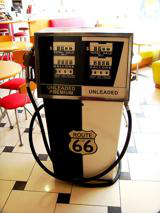

In [0]:
ll.train[0][0]

สั่ง resize รูปให้เป็น 128 ทั้งกว้าง ยาว

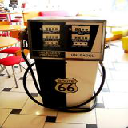

In [0]:
ll.train[0][0].resize((128, 128))

ประกาศ Class และ ฟังก์ชัน ในการ Transform - Resize, แปลง byte เป็น Tensor, แปลง Tensor Long เป็น Tensor Float กำหนด _order ตามลำดับ

In [0]:
class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int): size = (size, size)
        self.size = size
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(w, h, -1).permute(2, 0, 1)

to_byte_tensor._order = 20

def to_float_tensor(item): return item.float().div_(255.)

to_float_tensor._order = 30

ลอง Pipeline ของ DataBlock ใหม่ ตั้งแต่ต้น โดยพาส Transform tfms ที่เราสร้าง และกำหนดลำดับ \_order ไว้ก่อนหน้า 

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ประกาศฟังก์ชัน show\_image ที่แสดงรูป โดย permute Channel จากหน้าสุด ไปไว้หลังสุด เนื่องจาก Matplotlib ต้องการ channel หลังสุด เช่น 224, 224, 3 แต่ PyTorch เรียง Channel ไว้หน้าสุด เช่น 3, 224, 224

In [0]:
def show_image(im, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1, 2, 0))

ดึงข้อมูล Training Set ออกมา Record แรก แล้วดู shape

In [0]:
x, y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

เรียก show_image

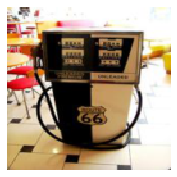

In [0]:
show_image(x)

# 7. DataLoader

เนื่องจากเราไม่สามารถโหลดทั้ง Dataset ขึ้น Memory ได้พร้อมกัน เราจำเป็นต้องใช้ DataLoader แบ่งข้อมูลออกเป็น Batch (Lazy Loading) โดยนับทั้งหมดมาสับไพ่ แล้วโหลดมา 1 Batch ขนาดตาม Batch Size

In [0]:
bs = 64 # batch size
nw = 8  # num workers

In [0]:
train_dl, valid_dl = DataLoader(ll.train, batch_size=bs, shuffle=True, num_workers=nw), DataLoader(ll.valid, batch_size=bs, num_workers=nw)

ลองดึงข้อมูลออกมา 1 Batch

In [0]:
xb, yb = next(iter(train_dl))

ดู Shape

In [0]:
xb.shape

torch.Size([64, 3, 128, 128])

แสดงรูป พร้อม Label ก่อนแปลง (ดึงจาก proc_y.vocab)

'n02979186'

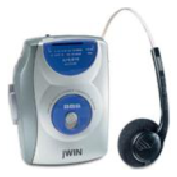

In [0]:
show_image(xb[0])
ll.train.proc_y.vocab[yb[0]]

แสดง Label ของทั้ง Batch ที่แปลง Categorize แล้ว

In [0]:
yb

tensor([3, 3, 9, 2, 1, 0, 9, 4, 2, 5, 0, 9, 7, 1, 7, 8, 5, 4, 0, 7, 9, 9, 8, 4,
        3, 6, 8, 8, 8, 6, 6, 6, 6, 1, 1, 7, 4, 1, 6, 0, 1, 6, 2, 5, 8, 9, 0, 9,
        8, 5, 9, 8, 5, 2, 2, 1, 9, 4, 3, 0, 4, 2, 3, 1])

# 8. DataBunch

DataBunch คือ การสร้าง class มาห่อทั้งหมดข้างบนไว้ (Training Set DataLoader, Validation Set DataLoader) ให้เป็นก้อนเดียว พร้อมใส่ข้อมูลเพิ่มเติม c\_in (Channel In), c\_out (Channel Out) ของโมเดล ที่จะสร้างต่อไป

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out

    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset


ประกาศฟังก์ชันอำนวยความสะดวก ในการสร้าง DataBunch และ เพิ่มไปเป็น method ของ class SplitData

In [0]:
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = DataLoader(sd.train, batch_size=bs, shuffle=True, **kwargs), DataLoader(sd.valid, batch_size=bs, **kwargs)
    return DataBunch(*dls, c_in, c_out)

SplitData.to_databunch = databunchify

# 9. สรุป

เราได้เรียนรู้ Pipeline ของการจัดเตรียมข้อมูลในทุกรูปแบบ เพื่อป้อนให้โมเดล เทรน Machine Learning แบบ Supervised Learning แบบง่าย ๆ แค่ 4 บรรทัด ดังด้านล่าง

In [0]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
databunch = ll.to_databunch(bs=bs, c_in=3, c_out=10, num_workers=8)

# Credit

* https://course.fast.ai/videos/?lesson=11
* https://github.com/fastai/imagenette
* https://docs.python.org/3/library/os.html
* https://pillow.readthedocs.io/en/stable/reference/Image.html
* https://pytorch.org/docs/stable/tensors.html
